## Loading the dataset

In [1]:
import pandas as pd
df = pd.read_csv("./mouth_year.csv")
df.head()

,production,p_per_m2,p_max,panel_area,facade_area,total_panel_area,exploitation_ratio,air_temp_mean,air_temp_max,clearsky_ghi_mean,...,relative_humidity_max,surface_pressure_mean,surface_pressure_min,surface_pressure_max,wind_direction_100m_mean,wind_direction_100m_min,wind_direction_100m_max,wind_speed_100m_mean,wind_speed_100m_min,wind_speed_100m_max
0,7.461290,143.0,210.0,1.72,218.0,94.6,0.434,1.885252,3.612903,72.773750,...,90.400000,1017.477354,1013.751613,1021.354839,213.224691,148.193548,273.870968,5.215817,3.112903,7.035484
1,3.100000,143.0,210.0,1.72,218.0,94.6,0.434,2.395833,4.000000,72.791667,...,90.600000,1017.168750,1015.500000,1021.000000,227.041667,192.000000,283.000000,4.781250,2.600000,7.400000
2,30.171429,143.0,210.0,1.72,218.0,94.6,0.434,5.704613,11.500000,120.002232,...,87.157143,1024.363914,1021.210714,1027.460714,179.183036,127.214286,233.535714,4.203720,2.382143,6.142857
3,39.050000,143.0,210.0,1.72,218.0,94.6,0.434,6.229167,12.000000,117.760417,...,90.050000,1026.685417,1023.400000,1030.000000,191.343750,154.000000,217.000000,3.611458,1.450000,5.500000
4,26.516129,143.0,210.0,1.72,218.0,94.6,0.434,8.653686,12.870968,189.389254,...,85.245161,1020.149565,1016.722581,1023.654839,180.347464,125.225806,232.806452,6.274361,3.974194,8.567742


## Preoaring the (x,y) pairs

### Scaling the data

In [2]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df.values)

### Creating windows

In [3]:
production_column = 'production'

def get_target_column_index(df, target_column):
    for i, column in enumerate(df.columns):
        if column == target_column:
            return i

    return -1

In [4]:
import numpy as np

def get_windows(data, window_size=10):
    x = []
    y = []

    for i in range(window_size, len(data)):
        x.append(data[i-window_size:i])
        y.append(data[i][get_target_column_index(df, production_column)])

    return np.array(x), np.array(y)

In [5]:
window_size = 2*12  # 2*1h window
x, y = get_windows(data_scaled, window_size=window_size)

x.shape, y.shape

((702, 24, 34), (702,))

### Splitting the data

In [6]:
train_split_index = int(0.8 * len(df))
test_split_index = int(0.9 * len(df))

x_train, y_train = x[:train_split_index], y[:train_split_index]
x_test, y_test = x[train_split_index:test_split_index], y[train_split_index:test_split_index]
x_val, y_val = x[test_split_index:], y[test_split_index:]

x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((580, 24, 34), (580,), (73, 24, 34), (73,), (49, 24, 34), (49,))

### Plotting the splits

In [7]:
import matplotlib.pyplot as plt


def plot_time_series(timesteps, values, label, format='-^', start=0, end=None):
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("date")
    plt.ylabel("production")

    plt.legend(fontsize=14)
    plt.grid(True)

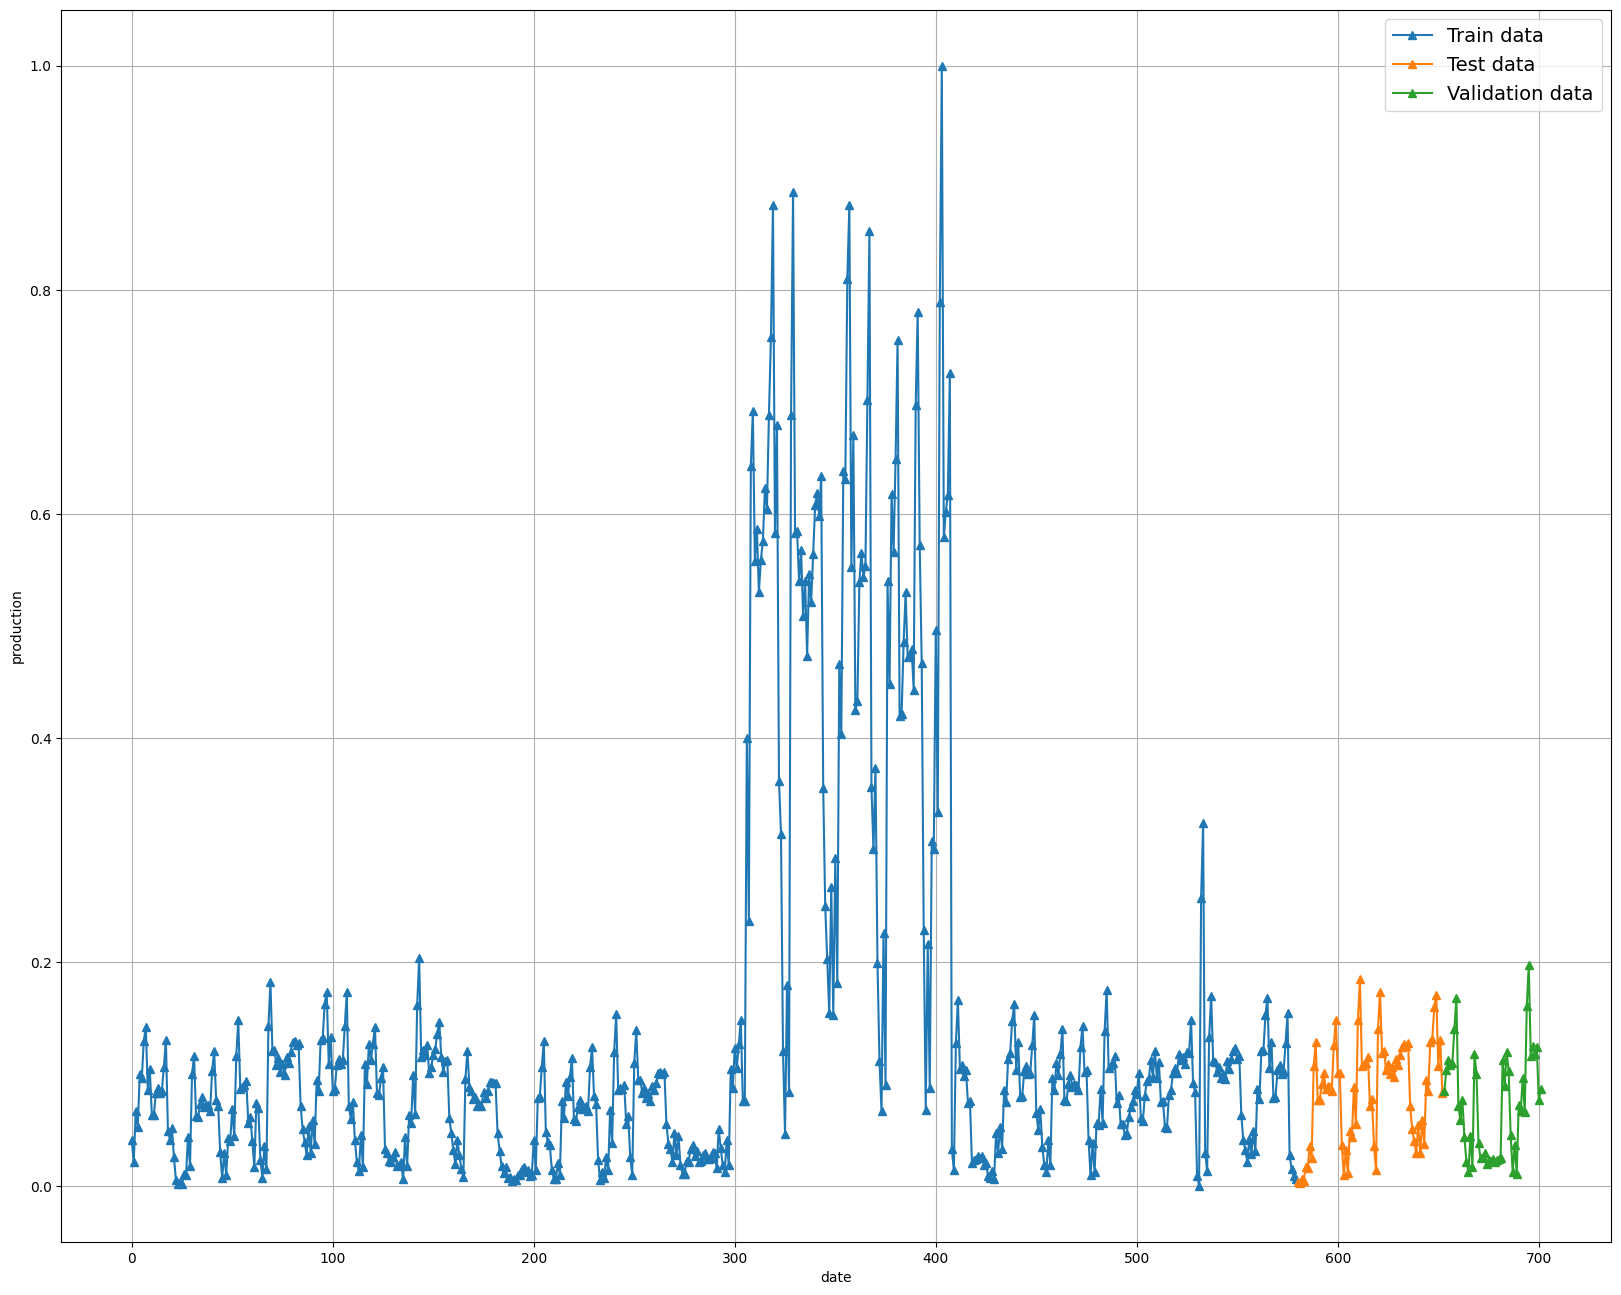

In [8]:
plt.figure(figsize=(20, 16))

timesteps = range(len(x_train))
plot_time_series(timesteps=timesteps, values=y_train, label="Train data")

timesteps = range(len(x_train), len(x_train) + len(x_test))
plot_time_series(timesteps=timesteps, values=y_test, label="Test data")

timesteps = range(len(x_train) + len(x_test),
                  len(x_train) + len(x_test) + len(x_val))
plot_time_series(timesteps=timesteps, values=y_val, label="Validation data")

### Preparing the performances metrics

In [9]:
import tensorflow as tf
from sklearn.metrics import r2_score

In [10]:
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    return {
        'mse': mse,
        'r2': r2,
        'mae': mae,
        'mape': mape,
    }

In [11]:
def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    mae_metric = tf.keras.metrics.MeanAbsoluteError()
    mse_metric = tf.keras.metrics.MeanSquaredError()

    mae_metric.update_state(y_true, y_pred)
    mse_metric.update_state(y_true, y_pred)

    mae = mae_metric.result().numpy()
    mse = mse_metric.result().numpy()
    r2 = r2_score(y_true.numpy(), y_pred.numpy())  # Assure-toi que y_true et y_pred sont des numpy arrays

    return {
        "mae": mae,
        "mse": mse,
        "r2": r2
    }

## Modeling

In [12]:
import os
import tensorflow as tf

from keras.layers import Dense, Dropout, LSTM, Flatten, ConvLSTM1D, MaxPool1D, GlobalMaxPool1D, Conv1D, Conv2D
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

### Plotting the loss

In [13]:
def plot_loss(history):
    plt.figure(figsize=(20, 8))

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

### Creating callbacks

In [14]:
stop_early = EarlyStopping(monitor='val_loss', patience=5)


def create_model_checkpoint(model_name, save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                              verbose=0,
                                              save_best_only=True)

### Utils function

In [15]:
def make_preds(model, input_data):
    forecast = model.predict(input_data)
    return tf.squeeze(forecast)

## ConvLSTM

#### Preparing the model

In [16]:
x_train_conv_lstm = np.expand_dims(x_train, axis=2)
x_val_conv_lstm = np.expand_dims(x_val, axis=2)
x_test_conv_lstm = np.expand_dims(x_test, axis=2)

print(f"{x_train.shape} -> {x_train_conv_lstm.shape}")

(580, 24, 34) -> (580, 24, 1, 34)


In [17]:
tf.random.set_seed(42)

input_shape = (x_train_conv_lstm.shape[1:])
conv_lstm_model = tf.keras.Sequential([
    ConvLSTM1D(filters=64, kernel_size=(1,), activation='tanh',
               return_sequences=True, input_shape=input_shape),
    ConvLSTM1D(filters=64, kernel_size=(1,),
               activation='tanh', return_sequences=False),
    Flatten(),
    Dense(units=64, activation='relu'),
    Dense(1, activation="linear")
], name="model_conv_lstm.keras")

conv_lstm_model.compile(loss="mae",
                        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

conv_lstm_model.summary()


Model: "model_conv_lstm.keras"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm1d (ConvLSTM1D)    (None, 24, 1, 64)         25344     
                                                                 
 conv_lstm1d_1 (ConvLSTM1D)  (None, 1, 64)             33024     
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 62593 (244.50 KB)
Trainable params: 62593 (244.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Training the model convlstm

In [18]:
import os
import time
import logging
from codecarbon import EmissionsTracker


os.makedirs('emissions', exist_ok=True)

tracker_conv_lstm = EmissionsTracker(
    project_name="PEWH",
    co2_signal_api_token="9RkoBO6iipmoq",
    log_level=logging.INFO,
    output_file="emissions_conv_lstm.csv",
    output_dir='./emissions/',
    save_to_file=True,
    measure_power_secs=10
)

[codecarbon INFO @ 03:19:50] [setup] RAM Tracking...
[codecarbon INFO @ 03:19:50] [setup] CPU Tracking...
[codecarbon WARNING @ 03:19:50] No CPU tracking mode found. Falling back on CPU constant mode. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon WARNING @ 03:19:52] We saw that you have a 12th Gen Intel(R) Core(TM) i7-12700H but we don't know it. Please contact us.
[codecarbon INFO @ 03:19:52] CPU Model on constant consumption mode: 12th Gen Intel(R) Core(TM) i7-12700H
[codecarbon INFO @ 03:19:52] [setup] GPU Tracking...
[codecarbon INFO @ 03:19:53] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 03:19:53] >>> Tracker's metadata:
[codecarbon INFO @ 03:19:53]   Platform system: Windows-10-10.0.22631-SP0
[codecarbon INFO @ 03:19:53]   Python version: 3.11.3
[codecarbon INFO @ 03:19:53]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 03:19:53]   Available RAM : 31.711 GB
[codecarbon INFO @ 03:19:53]   CPU count: 20
[codecarbon INFO @ 03:19:53]   CPU

In [19]:
def start_training_conv_lstm():
    start_time = time.time()
    conv_lstm_history = conv_lstm_model.fit(x=x_train_conv_lstm,
                                            y=y_train,
                                            epochs=300,
                                            verbose=1,
                                            batch_size=512,
                                            validation_data=(
                                                x_val_conv_lstm, y_val),
                                            callbacks=[create_model_checkpoint(model_name=conv_lstm_model.name)])
    training_duration = time.time() - start_time

    return conv_lstm_history, training_duration

In [20]:
tracker_conv_lstm.start()
try:
    history_conv_lstm, training_duration_conv_lstm = start_training_conv_lstm()
finally:
    tracker_conv_lstm.stop()

Epoch 1/300



[codecarbon INFO @ 03:20:05] Energy consumed for RAM : 0.000036 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 03:20:05] Energy consumed for all CPUs : 0.000129 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:20:06] Energy consumed for all GPUs : 0.000004 kWh. Total GPU Power : 1.399854094654181 W
[codecarbon INFO @ 03:20:06] 0.000169 kWh of electricity used since the beginning.


2/2 [==============================] - 14s 2s/step - loss: 0.4346 - val_loss: 0.0517
Epoch 2/300
2/2 [==============================] - 0s 176ms/step - loss: 0.1316 - val_loss: 0.0770
Epoch 3/300
2/2 [==============================] - 0s 282ms/step - loss: 0.1118 - val_loss: 0.0412
Epoch 4/300
2/2 [==============================] - 0s 182ms/step - loss: 0.0936 - val_loss: 0.0466
Epoch 5/300
2/2 [==============================] - 0s 194ms/step - loss: 0.0945 - val_loss: 0.0488
Epoch 6/300
2/2 [==============================] - 0s 182ms/step - loss: 0.0890 - val_loss: 0.0436
Epoch 7/300
2/2 [==============================] - 0s 181ms/step - loss: 0.0809 - val_loss: 0.0464
Epoch 8/300
2/2 [==============================] - 0s 265ms/step - loss: 0.0852 - val_loss: 0.0399
Epoch 9/300
2/2 [==============================] - 0s 188ms/step - loss: 0.0744 - val_loss: 0.0491
Epoch 10/300
2/2 [==============================] - 0s 267ms/step - loss: 0.0781 - val_loss: 0.0392
Epoch 11/300
2/2 [=====

[codecarbon INFO @ 03:20:15] Energy consumed for RAM : 0.000064 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 03:20:15] Energy consumed for all CPUs : 0.000231 kWh. Total CPU Power : 42.5 W


2/2 [==============================] - 0s 284ms/step - loss: 0.0616 - val_loss: 0.0386
Epoch 17/300
2/2 [==============================] - 0s 175ms/step - loss: 0.0630 - val_loss: 0.0410
Epoch 18/300
2/2 [==============================] - 0s 223ms/step - loss: 0.0612 - val_loss: 0.0372
Epoch 19/300
2/2 [==============================] - 0s 250ms/step - loss: 0.0599 - val_loss: 0.0369
Epoch 20/300
1/2 [==============>...............] - ETA: 0s - loss: 0.0597

[codecarbon INFO @ 03:20:16] Energy consumed for all GPUs : 0.000014 kWh. Total GPU Power : 3.9190207647279154 W
[codecarbon INFO @ 03:20:16] 0.000309 kWh of electricity used since the beginning.


2/2 [==============================] - 0s 157ms/step - loss: 0.0595 - val_loss: 0.0389
Epoch 21/300
2/2 [==============================] - 0s 242ms/step - loss: 0.0600 - val_loss: 0.0368
Epoch 22/300
2/2 [==============================] - 0s 174ms/step - loss: 0.0599 - val_loss: 0.0376
Epoch 23/300
2/2 [==============================] - 0s 268ms/step - loss: 0.0615 - val_loss: 0.0363
Epoch 24/300
2/2 [==============================] - 0s 190ms/step - loss: 0.0588 - val_loss: 0.0366
Epoch 25/300
2/2 [==============================] - 0s 274ms/step - loss: 0.0578 - val_loss: 0.0358
Epoch 26/300
2/2 [==============================] - 0s 176ms/step - loss: 0.0575 - val_loss: 0.0365
Epoch 27/300
2/2 [==============================] - 0s 180ms/step - loss: 0.0563 - val_loss: 0.0391
Epoch 28/300
2/2 [==============================] - 0s 191ms/step - loss: 0.0566 - val_loss: 0.0367
Epoch 29/300
2/2 [==============================] - 0s 173ms/step - loss: 0.0568 - val_loss: 0.0387
Epoch 30/300


[codecarbon INFO @ 03:20:25] Energy consumed for RAM : 0.000093 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 03:20:25] Energy consumed for all CPUs : 0.000333 kWh. Total CPU Power : 42.5 W


2/2 [==============================] - 0s 184ms/step - loss: 0.0500 - val_loss: 0.0374
Epoch 44/300
2/2 [==============================] - 0s 157ms/step - loss: 0.0497 - val_loss: 0.0377
Epoch 45/300
2/2 [==============================] - 0s 164ms/step - loss: 0.0494 - val_loss: 0.0356
Epoch 46/300
2/2 [==============================] - 0s 172ms/step - loss: 0.0491 - val_loss: 0.0378
Epoch 47/300
2/2 [==============================] - ETA: 0s - loss: 0.0485

[codecarbon INFO @ 03:20:26] Energy consumed for all GPUs : 0.000023 kWh. Total GPU Power : 3.985045849236874 W
[codecarbon INFO @ 03:20:26] 0.000449 kWh of electricity used since the beginning.


2/2 [==============================] - 0s 158ms/step - loss: 0.0485 - val_loss: 0.0355
Epoch 48/300
2/2 [==============================] - 0s 162ms/step - loss: 0.0478 - val_loss: 0.0369
Epoch 49/300
2/2 [==============================] - 0s 183ms/step - loss: 0.0473 - val_loss: 0.0355
Epoch 50/300
2/2 [==============================] - 0s 172ms/step - loss: 0.0485 - val_loss: 0.0371
Epoch 51/300
2/2 [==============================] - 0s 185ms/step - loss: 0.0469 - val_loss: 0.0359
Epoch 52/300
2/2 [==============================] - 0s 263ms/step - loss: 0.0458 - val_loss: 0.0351
Epoch 53/300
2/2 [==============================] - 0s 177ms/step - loss: 0.0457 - val_loss: 0.0370
Epoch 54/300
2/2 [==============================] - 0s 233ms/step - loss: 0.0462 - val_loss: 0.0350
Epoch 55/300
2/2 [==============================] - 0s 190ms/step - loss: 0.0457 - val_loss: 0.0356
Epoch 56/300
2/2 [==============================] - 0s 145ms/step - loss: 0.0440 - val_loss: 0.0366
Epoch 57/300


[codecarbon INFO @ 03:20:35] Energy consumed for RAM : 0.000121 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 03:20:35] Energy consumed for all CPUs : 0.000434 kWh. Total CPU Power : 42.5 W


2/2 [==============================] - 0s 184ms/step - loss: 0.0421 - val_loss: 0.0356
Epoch 73/300
2/2 [==============================] - 0s 160ms/step - loss: 0.0411 - val_loss: 0.0350
Epoch 74/300
2/2 [==============================] - 0s 168ms/step - loss: 0.0416 - val_loss: 0.0355
Epoch 75/300
2/2 [==============================] - 0s 177ms/step - loss: 0.0401 - val_loss: 0.0351
Epoch 76/300
2/2 [==============================] - ETA: 0s - loss: 0.0399

[codecarbon INFO @ 03:20:36] Energy consumed for all GPUs : 0.000033 kWh. Total GPU Power : 4.029399688864502 W
[codecarbon INFO @ 03:20:36] 0.000588 kWh of electricity used since the beginning.


2/2 [==============================] - 0s 147ms/step - loss: 0.0399 - val_loss: 0.0341
Epoch 77/300
2/2 [==============================] - 0s 164ms/step - loss: 0.0427 - val_loss: 0.0394
Epoch 78/300
2/2 [==============================] - 0s 175ms/step - loss: 0.0439 - val_loss: 0.0357
Epoch 79/300
2/2 [==============================] - 0s 196ms/step - loss: 0.0425 - val_loss: 0.0367
Epoch 80/300
2/2 [==============================] - 0s 191ms/step - loss: 0.0415 - val_loss: 0.0363
Epoch 81/300
2/2 [==============================] - 0s 181ms/step - loss: 0.0409 - val_loss: 0.0344
Epoch 82/300
2/2 [==============================] - 0s 191ms/step - loss: 0.0441 - val_loss: 0.0342
Epoch 83/300
2/2 [==============================] - 0s 167ms/step - loss: 0.0415 - val_loss: 0.0353
Epoch 84/300
2/2 [==============================] - 0s 184ms/step - loss: 0.0420 - val_loss: 0.0369
Epoch 85/300
2/2 [==============================] - 0s 178ms/step - loss: 0.0421 - val_loss: 0.0346
Epoch 86/300


[codecarbon INFO @ 03:20:45] Energy consumed for RAM : 0.000149 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 03:20:45] Energy consumed for all CPUs : 0.000536 kWh. Total CPU Power : 42.5 W


2/2 [==============================] - 0s 186ms/step - loss: 0.0396 - val_loss: 0.0338
Epoch 102/300
2/2 [==============================] - 0s 166ms/step - loss: 0.0383 - val_loss: 0.0340
Epoch 103/300
2/2 [==============================] - 0s 174ms/step - loss: 0.0378 - val_loss: 0.0350
Epoch 104/300
2/2 [==============================] - 0s 178ms/step - loss: 0.0383 - val_loss: 0.0352
Epoch 105/300
1/2 [==============>...............] - ETA: 0s - loss: 0.0395

[codecarbon INFO @ 03:20:46] Energy consumed for all GPUs : 0.000043 kWh. Total GPU Power : 4.160574196782423 W
[codecarbon INFO @ 03:20:46] 0.000728 kWh of electricity used since the beginning.


2/2 [==============================] - 0s 160ms/step - loss: 0.0391 - val_loss: 0.0343
Epoch 106/300
2/2 [==============================] - 0s 241ms/step - loss: 0.0381 - val_loss: 0.0326
Epoch 107/300
2/2 [==============================] - 0s 191ms/step - loss: 0.0388 - val_loss: 0.0330
Epoch 108/300
2/2 [==============================] - 0s 193ms/step - loss: 0.0399 - val_loss: 0.0331
Epoch 109/300
2/2 [==============================] - 0s 176ms/step - loss: 0.0376 - val_loss: 0.0332
Epoch 110/300
2/2 [==============================] - 0s 182ms/step - loss: 0.0405 - val_loss: 0.0355
Epoch 111/300
2/2 [==============================] - 0s 186ms/step - loss: 0.0397 - val_loss: 0.0327
Epoch 112/300
2/2 [==============================] - 0s 170ms/step - loss: 0.0378 - val_loss: 0.0351
Epoch 113/300
2/2 [==============================] - 0s 202ms/step - loss: 0.0422 - val_loss: 0.0329
Epoch 114/300
2/2 [==============================] - 0s 173ms/step - loss: 0.0384 - val_loss: 0.0336
Epoc

[codecarbon INFO @ 03:20:55] Energy consumed for RAM : 0.000178 kWh. RAM Power : 11.891499996185303 W


1/2 [==============>...............] - ETA: 0s - loss: 0.0412

[codecarbon INFO @ 03:20:55] Energy consumed for all CPUs : 0.000637 kWh. Total CPU Power : 42.5 W


2/2 [==============================] - 0s 208ms/step - loss: 0.0410 - val_loss: 0.0337
Epoch 131/300
2/2 [==============================] - 0s 152ms/step - loss: 0.0400 - val_loss: 0.0360
Epoch 132/300
2/2 [==============================] - 0s 168ms/step - loss: 0.0418 - val_loss: 0.0426
Epoch 133/300
2/2 [==============================] - 0s 162ms/step - loss: 0.0432 - val_loss: 0.0339
Epoch 134/300
2/2 [==============================] - ETA: 0s - loss: 0.0438

[codecarbon INFO @ 03:20:56] Energy consumed for all GPUs : 0.000052 kWh. Total GPU Power : 4.038889983917471 W
[codecarbon INFO @ 03:20:56] 0.000868 kWh of electricity used since the beginning.


2/2 [==============================] - 0s 175ms/step - loss: 0.0438 - val_loss: 0.0326
Epoch 135/300
2/2 [==============================] - 0s 168ms/step - loss: 0.0401 - val_loss: 0.0389
Epoch 136/300
2/2 [==============================] - 0s 165ms/step - loss: 0.0431 - val_loss: 0.0368
Epoch 137/300
2/2 [==============================] - 0s 195ms/step - loss: 0.0447 - val_loss: 0.0339
Epoch 138/300
2/2 [==============================] - 0s 184ms/step - loss: 0.0397 - val_loss: 0.0427
Epoch 139/300
2/2 [==============================] - 0s 189ms/step - loss: 0.0450 - val_loss: 0.0339
Epoch 140/300
2/2 [==============================] - 0s 181ms/step - loss: 0.0419 - val_loss: 0.0338
Epoch 141/300
2/2 [==============================] - 0s 186ms/step - loss: 0.0428 - val_loss: 0.0388
Epoch 142/300
2/2 [==============================] - 0s 178ms/step - loss: 0.0431 - val_loss: 0.0375
Epoch 143/300
2/2 [==============================] - 0s 179ms/step - loss: 0.0423 - val_loss: 0.0349
Epoc

[codecarbon INFO @ 03:21:05] Energy consumed for RAM : 0.000206 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 03:21:05] Energy consumed for all CPUs : 0.000739 kWh. Total CPU Power : 42.5 W


2/2 [==============================] - 0s 181ms/step - loss: 0.0387 - val_loss: 0.0344
Epoch 160/300
2/2 [==============================] - 0s 154ms/step - loss: 0.0373 - val_loss: 0.0350
Epoch 161/300
2/2 [==============================] - 0s 156ms/step - loss: 0.0386 - val_loss: 0.0337
Epoch 162/300
2/2 [==============================] - 0s 174ms/step - loss: 0.0382 - val_loss: 0.0354
Epoch 163/300
1/2 [==============>...............] - ETA: 0s - loss: 0.0381

[codecarbon INFO @ 03:21:06] Energy consumed for all GPUs : 0.000062 kWh. Total GPU Power : 4.150362336238314 W
[codecarbon INFO @ 03:21:06] 0.001008 kWh of electricity used since the beginning.


2/2 [==============================] - 0s 161ms/step - loss: 0.0379 - val_loss: 0.0358
Epoch 164/300
2/2 [==============================] - 0s 166ms/step - loss: 0.0379 - val_loss: 0.0321
Epoch 165/300
2/2 [==============================] - 0s 177ms/step - loss: 0.0373 - val_loss: 0.0328
Epoch 166/300
2/2 [==============================] - 0s 179ms/step - loss: 0.0379 - val_loss: 0.0358
Epoch 167/300
2/2 [==============================] - 0s 178ms/step - loss: 0.0410 - val_loss: 0.0332
Epoch 168/300
2/2 [==============================] - 0s 174ms/step - loss: 0.0369 - val_loss: 0.0333
Epoch 169/300
2/2 [==============================] - 0s 179ms/step - loss: 0.0388 - val_loss: 0.0346
Epoch 170/300
2/2 [==============================] - 0s 171ms/step - loss: 0.0370 - val_loss: 0.0370
Epoch 171/300
2/2 [==============================] - 0s 169ms/step - loss: 0.0381 - val_loss: 0.0329
Epoch 172/300
2/2 [==============================] - 0s 184ms/step - loss: 0.0364 - val_loss: 0.0326
Epoc

[codecarbon INFO @ 03:21:15] Energy consumed for RAM : 0.000234 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 03:21:15] Energy consumed for all CPUs : 0.000841 kWh. Total CPU Power : 42.5 W


2/2 [==============================] - 0s 188ms/step - loss: 0.0366 - val_loss: 0.0325
Epoch 189/300
2/2 [==============================] - 0s 169ms/step - loss: 0.0373 - val_loss: 0.0318
Epoch 190/300
2/2 [==============================] - 0s 153ms/step - loss: 0.0357 - val_loss: 0.0321
Epoch 191/300
2/2 [==============================] - 0s 166ms/step - loss: 0.0357 - val_loss: 0.0323
Epoch 192/300
2/2 [==============================] - 0s 178ms/step - loss: 0.0355 - val_loss: 0.0343
Epoch 193/300


[codecarbon INFO @ 03:21:16] Energy consumed for all GPUs : 0.000072 kWh. Total GPU Power : 4.056265011439074 W
[codecarbon INFO @ 03:21:16] 0.001147 kWh of electricity used since the beginning.


2/2 [==============================] - ETA: 0s - loss: 0.0362

[codecarbon INFO @ 03:21:16] 0.000348 g.CO2eq/s mean an estimation of 10.980512124301518 kg.CO2eq/year


2/2 [==============================] - 0s 155ms/step - loss: 0.0362 - val_loss: 0.0328
Epoch 194/300
2/2 [==============================] - 0s 183ms/step - loss: 0.0351 - val_loss: 0.0330
Epoch 195/300
2/2 [==============================] - 0s 185ms/step - loss: 0.0354 - val_loss: 0.0324
Epoch 196/300
2/2 [==============================] - 0s 268ms/step - loss: 0.0348 - val_loss: 0.0316
Epoch 197/300
2/2 [==============================] - 0s 184ms/step - loss: 0.0352 - val_loss: 0.0319
Epoch 198/300
2/2 [==============================] - 0s 165ms/step - loss: 0.0354 - val_loss: 0.0317
Epoch 199/300
2/2 [==============================] - 0s 263ms/step - loss: 0.0354 - val_loss: 0.0315
Epoch 200/300
2/2 [==============================] - 0s 171ms/step - loss: 0.0355 - val_loss: 0.0326
Epoch 201/300
2/2 [==============================] - 0s 186ms/step - loss: 0.0354 - val_loss: 0.0327
Epoch 202/300
2/2 [==============================] - 0s 161ms/step - loss: 0.0351 - val_loss: 0.0335
Epoc

[codecarbon INFO @ 03:21:25] Energy consumed for RAM : 0.000263 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 03:21:25] Energy consumed for all CPUs : 0.000943 kWh. Total CPU Power : 42.5 W


2/2 [==============================] - 0s 131ms/step - loss: 0.0343 - val_loss: 0.0309
Epoch 219/300
2/2 [==============================] - 0s 155ms/step - loss: 0.0338 - val_loss: 0.0321
Epoch 220/300
2/2 [==============================] - 0s 164ms/step - loss: 0.0347 - val_loss: 0.0328
Epoch 221/300
2/2 [==============================] - 0s 162ms/step - loss: 0.0358 - val_loss: 0.0344
Epoch 222/300
2/2 [==============================] - 0s 160ms/step - loss: 0.0349 - val_loss: 0.0316


[codecarbon INFO @ 03:21:26] Energy consumed for all GPUs : 0.000082 kWh. Total GPU Power : 4.130664522935475 W


Epoch 223/300


[codecarbon INFO @ 03:21:26] 0.001287 kWh of electricity used since the beginning.


2/2 [==============================] - 0s 148ms/step - loss: 0.0352 - val_loss: 0.0309
Epoch 224/300
2/2 [==============================] - 0s 151ms/step - loss: 0.0363 - val_loss: 0.0315
Epoch 225/300
2/2 [==============================] - 0s 164ms/step - loss: 0.0350 - val_loss: 0.0320
Epoch 226/300
2/2 [==============================] - 0s 163ms/step - loss: 0.0358 - val_loss: 0.0347
Epoch 227/300
2/2 [==============================] - 0s 144ms/step - loss: 0.0352 - val_loss: 0.0348
Epoch 228/300
2/2 [==============================] - 0s 172ms/step - loss: 0.0355 - val_loss: 0.0325
Epoch 229/300
2/2 [==============================] - 0s 168ms/step - loss: 0.0353 - val_loss: 0.0338
Epoch 230/300
2/2 [==============================] - 0s 170ms/step - loss: 0.0363 - val_loss: 0.0327
Epoch 231/300
2/2 [==============================] - 0s 237ms/step - loss: 0.0338 - val_loss: 0.0307
Epoch 232/300
2/2 [==============================] - 0s 165ms/step - loss: 0.0356 - val_loss: 0.0307
Epoc

[codecarbon INFO @ 03:21:35] Energy consumed for RAM : 0.000291 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 03:21:35] Energy consumed for all CPUs : 0.001044 kWh. Total CPU Power : 42.5 W


2/2 [==============================] - 0s 176ms/step - loss: 0.0331 - val_loss: 0.0315
Epoch 250/300
2/2 [==============================] - 0s 162ms/step - loss: 0.0329 - val_loss: 0.0304
Epoch 251/300
2/2 [==============================] - 0s 167ms/step - loss: 0.0332 - val_loss: 0.0299
Epoch 252/300
2/2 [==============================] - 0s 168ms/step - loss: 0.0339 - val_loss: 0.0309
Epoch 253/300
2/2 [==============================] - 0s 181ms/step - loss: 0.0339 - val_loss: 0.0309
Epoch 254/300


[codecarbon INFO @ 03:21:36] Energy consumed for all GPUs : 0.000092 kWh. Total GPU Power : 4.3910573485673705 W
[codecarbon INFO @ 03:21:36] 0.001428 kWh of electricity used since the beginning.


2/2 [==============================] - 0s 168ms/step - loss: 0.0328 - val_loss: 0.0294
Epoch 255/300
2/2 [==============================] - 0s 158ms/step - loss: 0.0340 - val_loss: 0.0302
Epoch 256/300
2/2 [==============================] - 0s 169ms/step - loss: 0.0348 - val_loss: 0.0300
Epoch 257/300
2/2 [==============================] - 0s 178ms/step - loss: 0.0320 - val_loss: 0.0307
Epoch 258/300
2/2 [==============================] - 0s 179ms/step - loss: 0.0334 - val_loss: 0.0312
Epoch 259/300
2/2 [==============================] - 0s 249ms/step - loss: 0.0340 - val_loss: 0.0294
Epoch 260/300
2/2 [==============================] - 0s 249ms/step - loss: 0.0324 - val_loss: 0.0289
Epoch 261/300
2/2 [==============================] - 0s 182ms/step - loss: 0.0330 - val_loss: 0.0303
Epoch 262/300
2/2 [==============================] - 0s 171ms/step - loss: 0.0329 - val_loss: 0.0316
Epoch 263/300
2/2 [==============================] - 0s 180ms/step - loss: 0.0334 - val_loss: 0.0359
Epoc

[codecarbon INFO @ 03:21:45] Energy consumed for RAM : 0.000320 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 03:21:45] Energy consumed for all CPUs : 0.001146 kWh. Total CPU Power : 42.5 W


2/2 [==============================] - 0s 176ms/step - loss: 0.0328 - val_loss: 0.0308
Epoch 281/300
2/2 [==============================] - 0s 176ms/step - loss: 0.0347 - val_loss: 0.0301
Epoch 282/300
2/2 [==============================] - 0s 158ms/step - loss: 0.0338 - val_loss: 0.0299
Epoch 283/300
2/2 [==============================] - 0s 183ms/step - loss: 0.0320 - val_loss: 0.0293
Epoch 284/300


[codecarbon INFO @ 03:21:46] Energy consumed for all GPUs : 0.000102 kWh. Total GPU Power : 4.1682678185942645 W
[codecarbon INFO @ 03:21:46] 0.001568 kWh of electricity used since the beginning.


2/2 [==============================] - 0s 238ms/step - loss: 0.0331 - val_loss: 0.0277
Epoch 285/300
2/2 [==============================] - 0s 177ms/step - loss: 0.0329 - val_loss: 0.0281
Epoch 286/300
2/2 [==============================] - 0s 176ms/step - loss: 0.0319 - val_loss: 0.0298
Epoch 287/300
2/2 [==============================] - 0s 185ms/step - loss: 0.0315 - val_loss: 0.0305
Epoch 288/300
2/2 [==============================] - 0s 176ms/step - loss: 0.0319 - val_loss: 0.0311
Epoch 289/300
2/2 [==============================] - 0s 176ms/step - loss: 0.0318 - val_loss: 0.0301
Epoch 290/300
2/2 [==============================] - 0s 184ms/step - loss: 0.0319 - val_loss: 0.0296
Epoch 291/300
2/2 [==============================] - 0s 175ms/step - loss: 0.0316 - val_loss: 0.0301
Epoch 292/300
2/2 [==============================] - 0s 175ms/step - loss: 0.0319 - val_loss: 0.0292
Epoch 293/300
2/2 [==============================] - 0s 182ms/step - loss: 0.0331 - val_loss: 0.0295
Epoc

[codecarbon INFO @ 03:21:52] Energy consumed for RAM : 0.000338 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 03:21:52] Energy consumed for all CPUs : 0.001211 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:21:53] Energy consumed for all GPUs : 0.000113 kWh. Total GPU Power : 6.658720323111671 W
[codecarbon INFO @ 03:21:53] 0.001662 kWh of electricity used since the beginning.


#### Ploting the loss

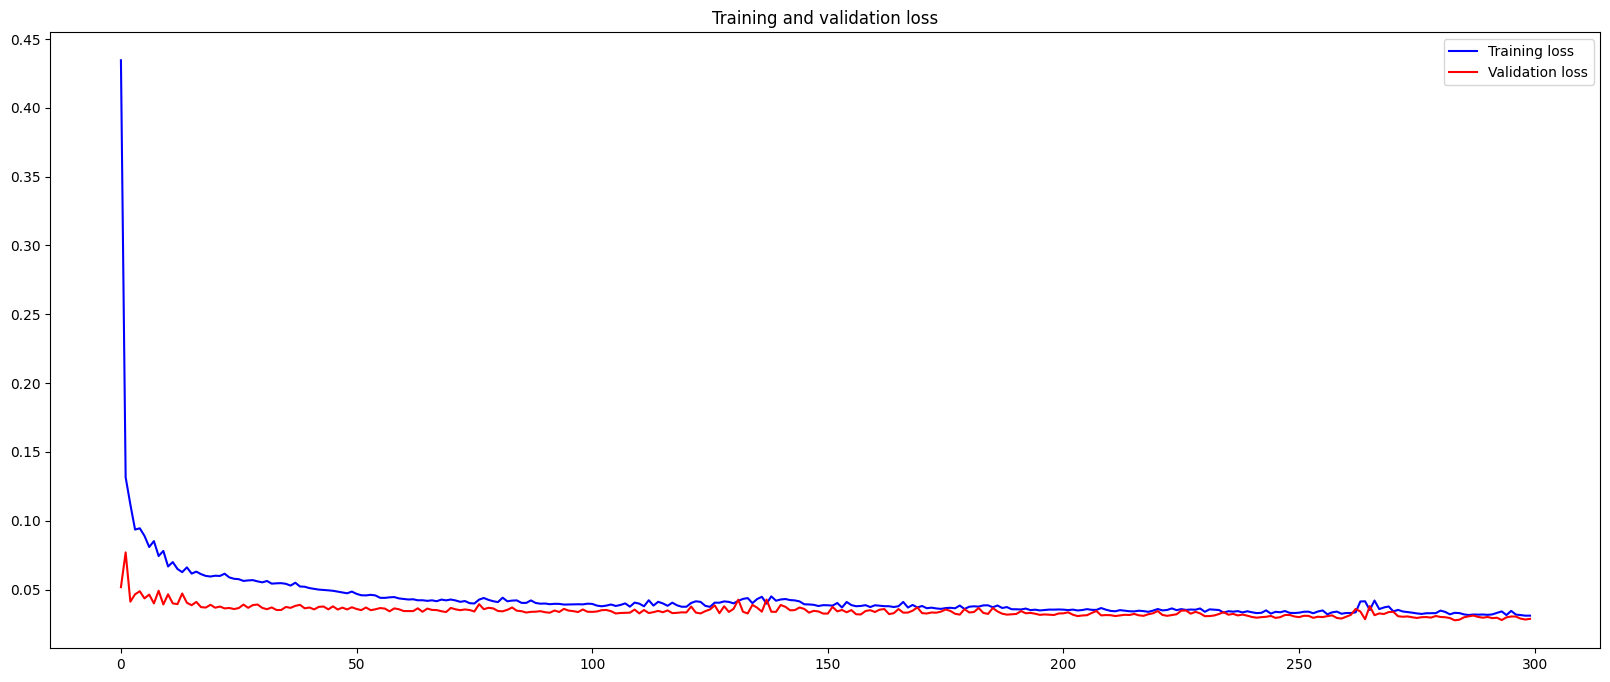

In [21]:
plot_loss(history_conv_lstm)

In [22]:
conv_lstm_model = tf.keras.models.load_model(
    "model_experiments/model_conv_lstm.keras")

model_preds = make_preds(conv_lstm_model, x_test_conv_lstm)
model_results = evaluate_preds(y_true=tf.squeeze(y_test),
                               y_pred=model_preds)

model_results

3/3 [==============================] - 1s 25ms/step


{'mae': 0.020350082, 'mse': 0.00077770127, 'r2': 0.6268689632415771}

#### Plot predictions

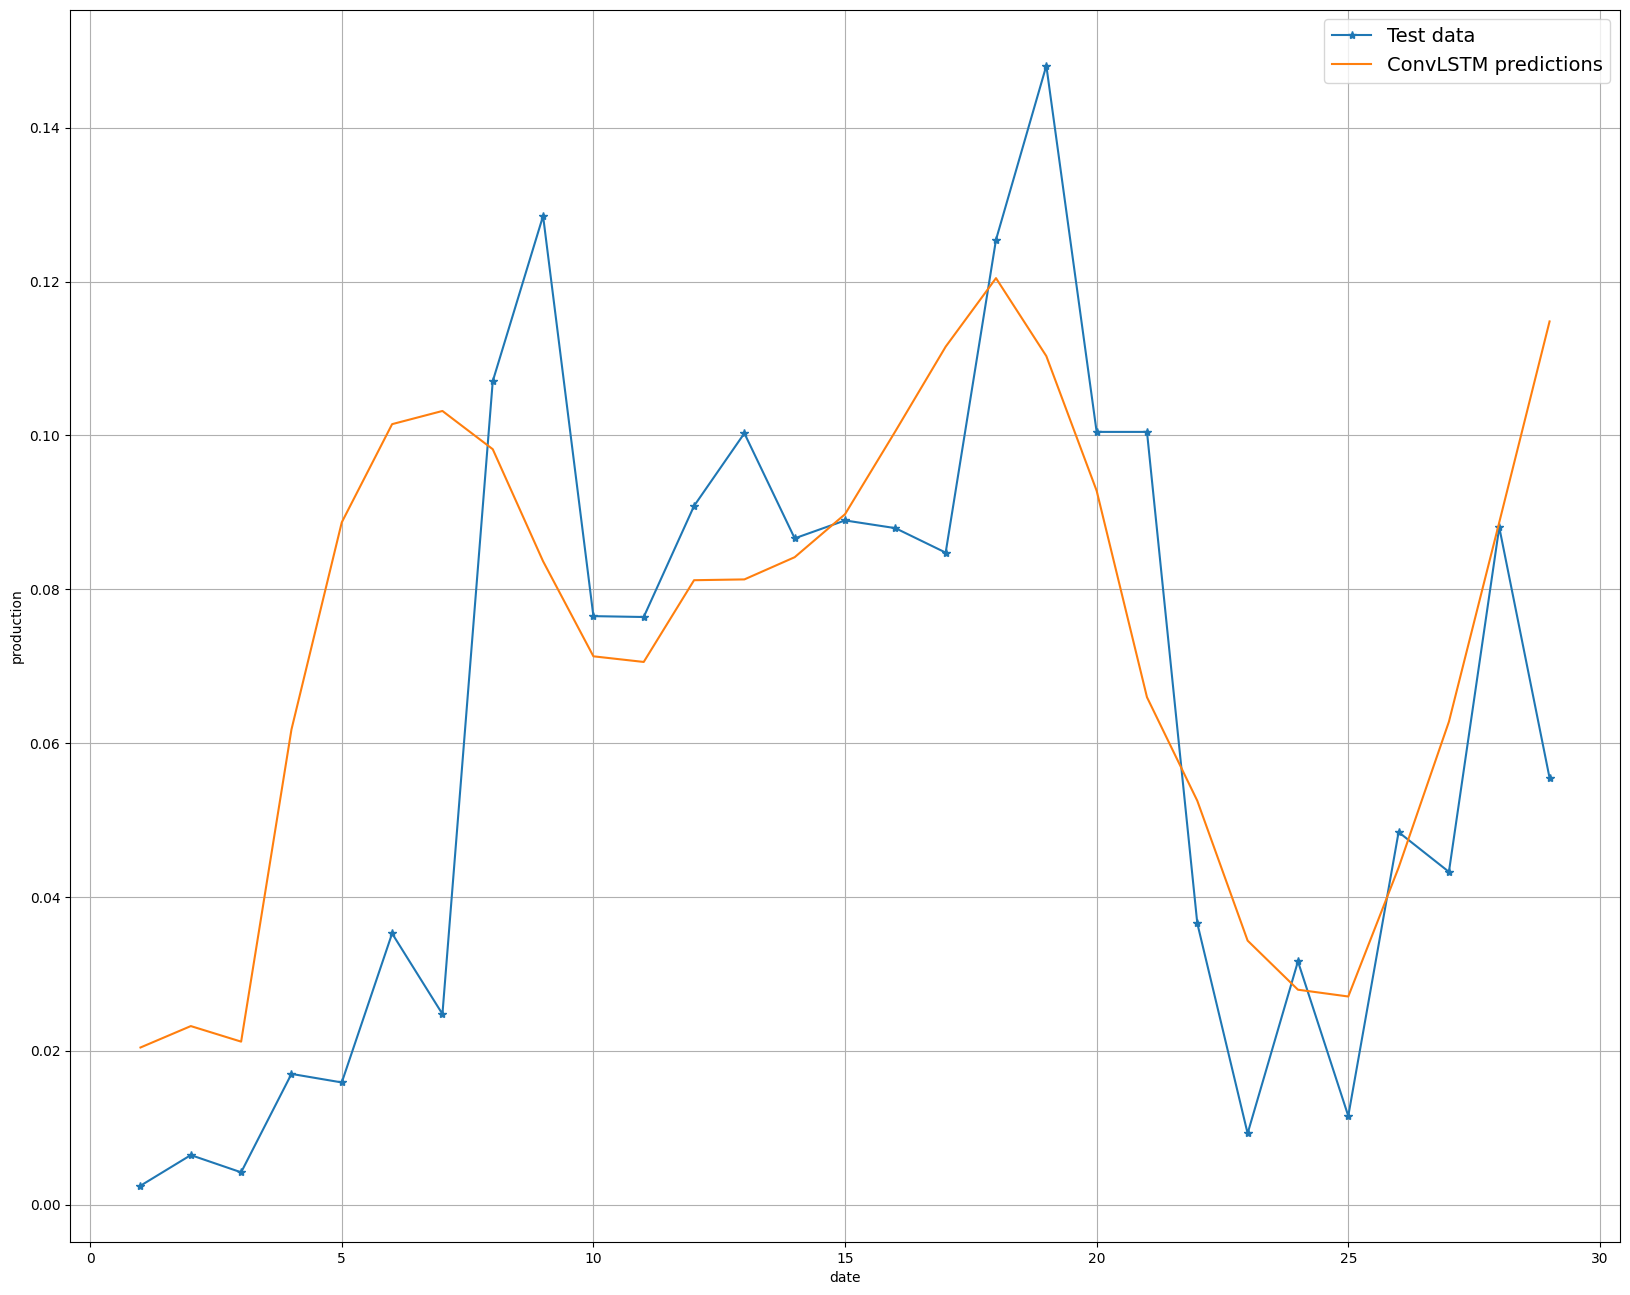

In [23]:
import numpy as np

start_offset = 1
end_offset = 30
plt.figure(figsize=(20, 16))


plot_time_series(
    timesteps=np.arange(x_test.shape[0]),
    values=y_test,
    start=start_offset,
    end=end_offset,
    format='-*',
    label="Test data"
)

plot_time_series(
    timesteps=np.arange(x_test.shape[0]),
    values=model_preds,
    start=start_offset,
    end=end_offset,
    format="-",
    label="ConvLSTM predictions"
)

In [24]:
import time
from deap import base, creator, tools
import random

# ========= Fonction modèle =========
def create_model(filters, kernel_size, activation, dense_units, learning_rate):
    model = tf.keras.Sequential([
        tf.keras.layers.ConvLSTM1D(filters=int(filters), kernel_size=(int(kernel_size),), activation=activation,
                                   return_sequences=True, input_shape=x_train_conv_lstm.shape[1:]),
        tf.keras.layers.ConvLSTM1D(filters=int(filters), kernel_size=(int(kernel_size),), activation=activation,
                                   return_sequences=False),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=int(dense_units), activation='relu'),
        tf.keras.layers.Dense(1, activation="linear")
    ])
    model.compile(loss="mae", optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    return model

# ========= Fonction évaluation =========
def evaluate(individual):
    filters, kernel_size, activation, dense_units, learning_rate = individual
    model = create_model(filters, kernel_size, activation, dense_units, learning_rate)
    
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=1,
        restore_best_weights=True
    )
    
    history = model.fit(
        x_train_conv_lstm, y_train,
        epochs=2,
        batch_size=128,
        verbose=0,
        validation_data=(x_val_conv_lstm, y_val),
        callbacks=[early_stop]
    )
    
    mae = history.history['val_loss'][-1]
    return (mae,)

# ========= Mutation et croisement =========
def mut_mixed(ind, indpb=0.2):
    for i in range(len(ind)):
        if i == 1:
            continue
        if random.random() < indpb:
            if isinstance(ind[i], float):
                ind[i] += random.gauss(0, 0.001)
                ind[i] = max(0.0001, min(0.01, ind[i]))
            elif isinstance(ind[i], int):
                ind[i] += random.randint(-8, 8)
                ind[i] = max(1, min(256, ind[i]))
            elif isinstance(ind[i], str):
                ind[i] = 'relu' if ind[i] == 'tanh' else 'tanh'
    return ind,

def cx_mixed(ind1, ind2):
    for i in range(len(ind1)):
        if random.random() < 0.5:
            ind1[i], ind2[i] = ind2[i], ind1[i]
    return ind1, ind2

# ========= Configuration DEAP =========
if not hasattr(creator, "FitnessMin"):
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
if not hasattr(creator, "Individual"):
    creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("filters", random.choice, [32, 64, 128])
toolbox.register("kernel_size", random.choice, [1])
toolbox.register("activation", random.choice, ['relu', 'tanh'])
toolbox.register("dense_units", random.choice, [32, 64, 128])
toolbox.register("learning_rate", random.uniform, 0.0001, 0.008)

toolbox.register("individual", tools.initCycle, creator.Individual,
    (toolbox.filters, toolbox.kernel_size, toolbox.activation, toolbox.dense_units, toolbox.learning_rate), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", cx_mixed)
toolbox.register("mutate", mut_mixed, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# ========= Exécution GA avec meilleur global =========
start_ga_time = time.time()

n_generations = 4
population_size = 10

population = toolbox.population(n=population_size)
best_overall = None

for gen in range(n_generations):
    print(f"\n Génération {gen+1}")
    fitnesses = list(map(toolbox.evaluate, population))
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit

    # Suivi du meilleur global
    gen_best = tools.selBest(population, 1)[0]
    if best_overall is None or gen_best.fitness.values[0] < best_overall.fitness.values[0]:
        best_overall = creator.Individual(gen_best)
        best_overall.fitness.values = gen_best.fitness.values

    print(" Population :")
    for i, ind in enumerate(population):
        print(f"  ➤ Individu {i+1}: {ind} ➤ MAE = {ind.fitness.values[0]:.4f}")

    offspring = toolbox.select(population, len(population))
    offspring = list(map(toolbox.clone, offspring))

    for c1, c2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < 0.5:
            toolbox.mate(c1, c2)
            del c1.fitness.values, c2.fitness.values

    for mutant in offspring:
        if random.random() < 0.2:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    invalids = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = list(map(toolbox.evaluate, invalids))
    for ind, fit in zip(invalids, fitnesses):
        ind.fitness.values = fit

    population[:] = offspring

end_ga_time = time.time()

# ========= Réentraînement final =========
print(f"\n Meilleurs hyperparamètres globaux trouvés : {best_overall}")
filters, kernel_size, activation, dense_units, learning_rate = best_overall
model = create_model(filters, kernel_size, activation, dense_units, learning_rate)

start_train_opt = time.time()
model.fit(x_train_conv_lstm, y_train, epochs=30, batch_size=512, verbose=0,
          validation_data=(x_val_conv_lstm, y_val))
training_time_opt = time.time() - start_train_opt

# ========= Évaluation finale =========
y_pred = model.predict(x_test_conv_lstm)
r2 = r2_score(y_test, y_pred)
mae_metric = tf.keras.metrics.MeanAbsoluteError()
mae_metric.update_state(y_test, y_pred)
mae = mae_metric.result().numpy()


# ========= Affichage final =========
print("\n Résumé des performances :")
print(f"  ➤ R² de base              : {model_results['r2']:.4f}")
print(f"  ➤ MAE de base             : {model_results['mae']:.4f}")
print(f"  ➤ Temps entraînement base : {training_duration_conv_lstm:.2f} s")
print(f"  ➤ R² optimisé             : {r2:.4f}")
print(f"  ➤ MAE optimisé            : {mae:.4f}")
print(f"  ➤ Temps entraînement opti : {training_time_opt:.2f} s")
print(f"  ➤ Temps GA total          : {end_ga_time - start_ga_time:.2f} s")
print(f"  ➤ Hyperparamètres choisis : {best_overall}")



 Génération 1
 Population :
  ➤ Individu 1: [32, 1, 'tanh', 32, 0.0028626602844543667] ➤ MAE = 0.0391
  ➤ Individu 2: [32, 1, 'tanh', 64, 0.0025360526576190816] ➤ MAE = 0.0420
  ➤ Individu 3: [128, 1, 'tanh', 64, 0.001237093550943531] ➤ MAE = 0.0516
  ➤ Individu 4: [32, 1, 'tanh', 128, 0.0007711436272844879] ➤ MAE = 0.0415
  ➤ Individu 5: [64, 1, 'tanh', 32, 0.0022145924270350528] ➤ MAE = 0.0444
  ➤ Individu 6: [64, 1, 'tanh', 64, 0.003665029648190086] ➤ MAE = 0.0550
  ➤ Individu 7: [32, 1, 'tanh', 32, 0.007051927669270832] ➤ MAE = 0.0402
  ➤ Individu 8: [128, 1, 'tanh', 64, 0.0010960363065549413] ➤ MAE = 0.0418
  ➤ Individu 9: [128, 1, 'relu', 128, 0.0045702007778225615] ➤ MAE = 0.0409
  ➤ Individu 10: [64, 1, 'relu', 32, 0.0010645440160447926] ➤ MAE = 0.0481

 Génération 2
 Population :
  ➤ Individu 1: [32, 1, 'tanh', 32, 0.0028626602844543667] ➤ MAE = 0.0610
  ➤ Individu 2: [32, 1, 'tanh', 128, 0.0007711436272844879] ➤ MAE = 0.0400
  ➤ Individu 3: [128, 1, 'tanh', 128, 0.0045702007